### Import necessary libraries

In [2]:
#Machine Learning
import os
import tensorflow as tf
import keras
from keras import layers
#Maths/Plotting
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

2023-08-08 17:38:57.011818: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-08 17:38:57.195345: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-08 17:38:57.196440: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-08 17:38:58.382789: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Set the parameters

In [3]:
#Parameters
k_f_0, k_r_0, k_cat_0 = [0.71, 0.97], [19, 7000], [6700, 10000]
params_0 = [k_f_0,k_r_0,k_cat_0]
s0, e, s1, s2 = 5.0, 0.66, 0, 0
val_0 = np.array([s0,s1,s2]) #Start values

def param(k_f, k_r, k_cat):
    k1 = e*((k_f[0]*k_cat[0])/(k_r[0]+k_cat[0]))
    k2 = e*((k_f[1]*k_cat[1])/(k_r[1]+k_cat[1]))
    pi = k_cat[1]/(k_r[1]+k_cat[1]) #zero-based indexing
    return k1, k2, pi

### Set up the differential equation function

In [4]:
def f(val, params):
    k1, k2, pi = param(params[0], params[1], params[2])
    mul_ar = np.array([[-k1, 0, 0],
                       [k1*(1-pi), -k2, 0],
                       [k1*pi, k2, 0]])
    return mul_ar.dot(val)

### Runge-Kutta method

In [5]:
#Runge-Kutta method
def f_rk(val, params, dt):
    k_1 = f(val, params)*dt
    k_2 = f(val + 0.5*k_1, params)*dt
    k_3 = f(val + 0.5*k_2, params)*dt
    k_4 = f(val + k_3, params)*dt
    nval = val + (1/6)*(k_1 + 2*k_2 + 2*k_3 + k_4)
    return nval

data_map_in, data_map_out, data_dif_in, data_dif_out = [], [], [], []

def integration(params, dt, steps):
    global data_map_in, data_map_out, data_dif_in, data_dif_out
    res = []
    res.append([0.0, val_0, val_0])
    val_rk = val_0
    time = 0.0
    for i in range(steps):
        data_map_in.append([val_rk[0], val_rk[1], val_rk[2], params[0][0], params[0][1], params[1][0], params[1][1], params[2][0], params[2][1]])
        data_map_out.append(f_rk(val_rk, params, dt))
        data_dif_in.append([val_rk[0], val_rk[1], val_rk[2], params[0][0], params[0][1], params[1][0], params[1][1], params[2][0], params[2][1]])
        data_dif_out.append(f(val_rk, params))
        val_rk = f_rk(val_rk, params, dt)
        time += dt
        res.append([time, val_rk])
        #print(i, [time, val_rk])
    res = np.array(res, dtype = object)
    return res

### Plotting the results and collecting data for Neural Network training

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


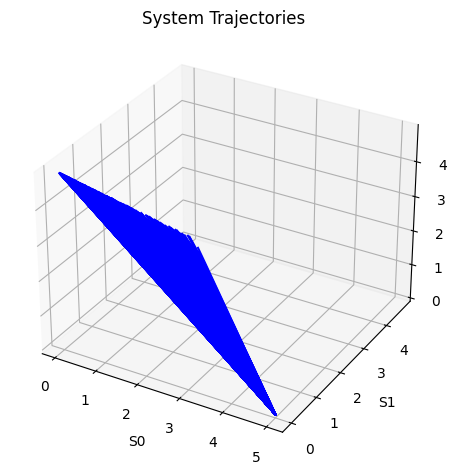

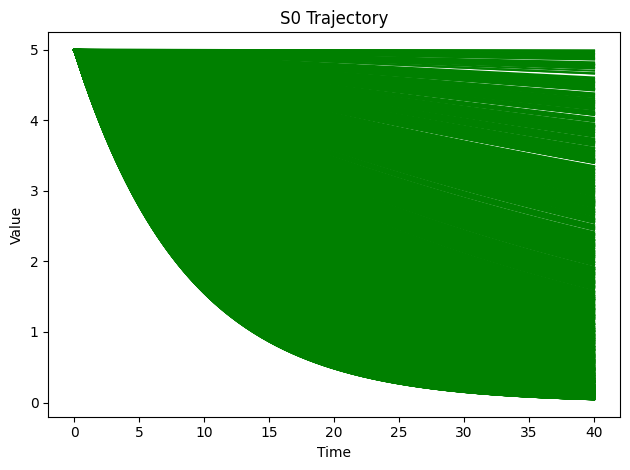

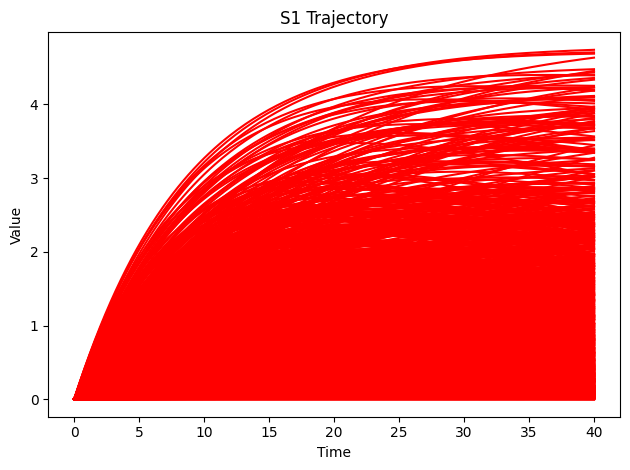

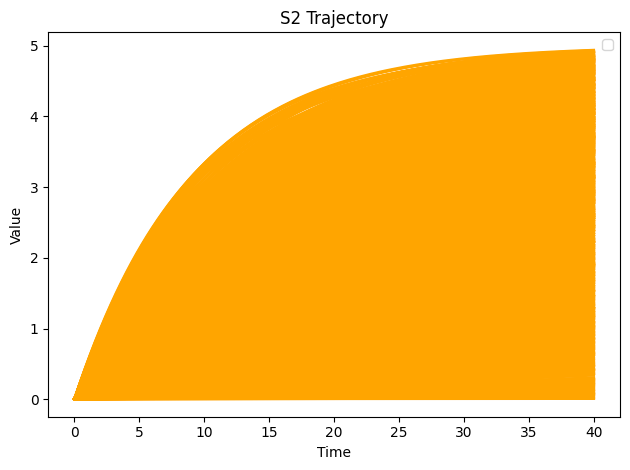

In [7]:
# Plot
ax = plt.figure().add_subplot(projection='3d')
ax2 = plt.figure().add_subplot()
ax3 = plt.figure().add_subplot()
ax4 = plt.figure().add_subplot()

def add_trajectory(params, dt=0.2, steps=200):
    res = integration(params, dt, steps)
    ax.plot([row[1][0] for row in res], [row[1][1] for row in res], [row[1][2] for row in res], color="blue")#Runge Kutta plot
    ax2.plot([row[0] for row in res], [row[1][0] for row in res], color="green")
    ax3.plot([row[0] for row in res], [row[1][1] for row in res], color="red")
    ax4.plot([row[0] for row in res], [row[1][2] for row in res], color="orange")

ran_sam = np.random.random_sample(size=(2000, 3, 2))
ran_sam = [(sam*0.25+np.array([[0.5,0.5],[0.5,0.5],[0.5,0.5]])*1.5) for sam in ran_sam]#random sample of deviation -75% -> -100%
for s in ran_sam:
    add_trajectory(np.array(params_0)-np.multiply(params_0,s))

# space_sam = np.linspace(-0.2, 0.2, num=4)
# twod_sam = np.array(np.meshgrid(space_sam, space_sam)).T.reshape(-1, 2)#deviation for each pair of parameters

# for i in twod_sam:
#     for j in twod_sam:
#         for k in twod_sam:
#             #apply the deviation to each parameter separately
#             dev = np.array([i,j,k])
#             add_trajectory(np.array(params_0)+np.multiply(params_0,dev))

#collect data from the trajectories for training/testing
data_map_in = np.array(data_map_in, dtype = object)
data_map_out = np.array(data_map_out, dtype = object)
data_dif_in = np.array(data_dif_in, dtype = object)
data_dif_out = np.array(data_dif_out, dtype = object)

plt.rcParams["figure.autolayout"] = True
leg = plt.legend(loc='upper right')
# Set axes labels
ax.set_xlabel("S0")
ax.set_ylabel("S1")
ax.set_zlabel("S2")
ax.set_title("System Trajectories")

ax2.set_xlabel("Time")
ax2.set_ylabel("Value")
ax2.set_title("S0 Trajectory")

ax3.set_xlabel("Time")
ax3.set_ylabel("Value")
ax3.set_title("S1 Trajectory")

ax4.set_xlabel("Time")
ax4.set_ylabel("Value")
ax4.set_title("S2 Trajectory")

plt.show()

### Making training and test data

In [8]:
#separating training from testing data and features from labels
data_map_pdin = pd.DataFrame(data_map_in.tolist(), columns = ["S0","S1","S2","KF1", "KF2", "KR1", "KR2", "KCAT1", "KCAT2"])
data_map_pdout = pd.DataFrame(data_map_out.tolist(), columns = ["nS0","nS1","nS2"])#n means new
data_map_pd = pd.concat([data_map_pdin,data_map_pdout],axis=1)
data_dif_pdin = pd.DataFrame(data_dif_in.tolist(), columns = ["S0","S1","S2","KF1", "KF2", "KR1", "KR2", "KCAT1", "KCAT2"])
data_dif_pdout = pd.DataFrame(data_dif_out.tolist(), columns = ["dotS0","dotS1","dotS2"])
data_dif_pd = pd.concat([data_dif_pdin,data_dif_pdout],axis=1)

train_map = data_map_pd.sample(frac=0.8, random_state=0)
test_map = data_map_pd.drop(train_map.index)

train_dif = data_dif_pd.sample(frac=0.8, random_state=0)
test_dif = data_dif_pd.drop(train_dif.index)

train_map_features = np.asarray(train_map[["S0","S1","S2","KF1", "KF2", "KR1", "KR2", "KCAT1", "KCAT2"]].copy())
train_map_labels = np.asarray(train_map[["nS0","nS1","nS2"]].copy())
test_map_features = np.asarray(test_map[["S0","S1","S2","KF1", "KF2", "KR1", "KR2", "KCAT1", "KCAT2"]].copy())
test_map_labels = np.asarray(test_map[["nS0","nS1","nS2"]].copy())

train_dif_features = train_dif[["S0","S1","S2","KF1", "KF2", "KR1", "KR2", "KCAT1", "KCAT2"]].copy()
train_dif_labels = train_dif[["dotS0","dotS1","dotS2"]].copy()
test_dif_features = test_dif[["S0","S1","S2","KF1", "KF2", "KR1", "KR2", "KCAT1", "KCAT2"]].copy()
test_dif_labels = test_dif[["dotS0","dotS1","dotS2"]].copy()

### Building and training the time-1 map model

In [9]:
normalizer_map = layers.Normalization(axis=-1)
normalizer_map.adapt(np.array(train_map_features))
model_map = keras.Sequential(
    [
        normalizer_map,
        layers.Dense(15, activation="relu"),
        layers.Dense(15, activation="relu"),
        layers.Dense(3)
    ]
)
model_map.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(0.001))
model_map.summary()

history_map = model_map.fit(
    train_map_features,
    train_map_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

model_map.save("model_map_params.tf", save_format="tf")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 9)                 19        
 on)                                                             
                                                                 
 dense (Dense)               (None, 15)                150       
                                                                 
 dense_1 (Dense)             (None, 15)                240       
                                                                 
 dense_2 (Dense)             (None, 3)                 48        
                                                                 
Total params: 457 (1.79 KB)
Trainable params: 438 (1.71 KB)
Non-trainable params: 19 (80.00 Byte)
_________________________________________________________________
INFO:tensorflow:Assets written to: model_map_params.tf/assets


INFO:tensorflow:Assets written to: model_map_params.tf/assets


### Evaluating the model

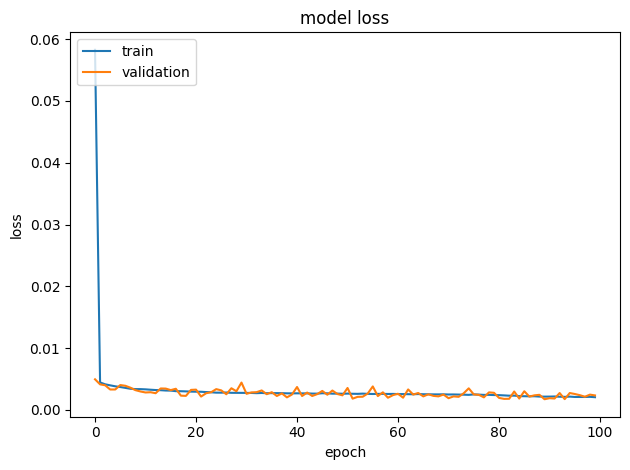

Evaluate on training data
2500/2500 [==============================] - 4s 1ms/step - loss: 0.0023
training loss: 0.0023277720902115107
Evaluate on test data
625/625 [==============================] - 1s 1ms/step - loss: 0.0023
test loss: 0.0023304636124521494


In [10]:
# Loss
plt.plot(history_map.history['loss'])
plt.plot(history_map.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Evaluate the model on the test data using `evaluate`
print("Evaluate on training data")
results = model_map.evaluate(train_map_features, train_map_labels, batch_size=128)
print("training loss:", results)
print("Evaluate on test data")
results = model_map.evaluate(test_map_features, test_map_labels, batch_size=128)
print("test loss:", results)

1/1 [==============================] - 0s 16ms/step


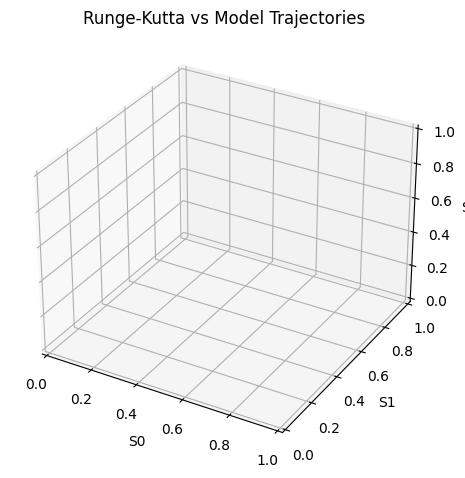

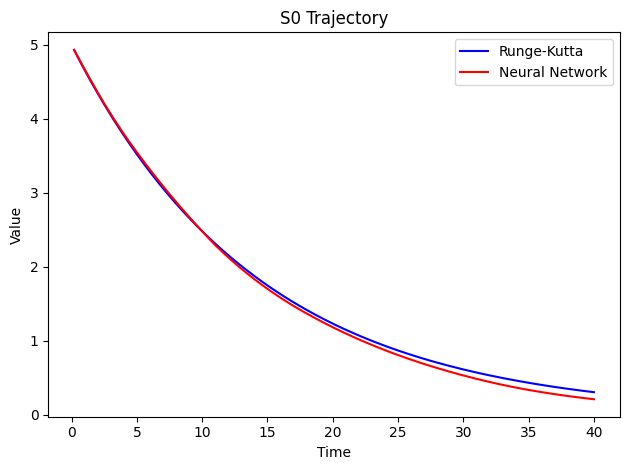

In [20]:
model_map = keras.models.load_model("model_map_params.tf")
dt = 0.2
steps = 200
ax5 = plt.figure().add_subplot(projection='3d')
ax6 = plt.figure().add_subplot()

def integrate2(params):
    res_ar = []
    val_model = val_rk = val_0
    time = 0.0
    for i in range(steps):
        val_rk = f_rk(val_rk, params, dt)
        #print(val_rk)
        #print(np.concatenate((val_model, np.array(params_0).flatten())))
        val_model = model_map.predict(np.concatenate((val_model, np.array(params).flatten())))[0]
        time += dt
        res_ar.append([time, val_model, val_rk])
    res_ar = np.array(res_ar, dtype = object)
    return res_ar
def add_trajectory2(params):
    res_ar = integrate2(params)
    # ax5.plot([row[0] for row in res_ar[:,2]], [row[1] for row in res_ar[:,2]], [row[2] for row in res_ar[:,2]], color="blue", label="Runge Kutta")#Runge Kutta plot
    # ax5.plot([row[0] for row in res_ar[:,1]], [row[1] for row in res_ar[:,1]], [row[2] for row in res_ar[:,1]], color="red", label="Model Predicted")#Model predicted plot
    ax6.plot(res_ar[:,0], [row[0] for row in res_ar[:,2]], color="blue", label="Runge-Kutta")
    ax6.plot(res_ar[:,0], [row[0] for row in res_ar[:,1]], color="red", label="Neural Network")

# ran_sam = np.random.random_sample(size=(10, 3, 2))
# ran_sam = [(sam*0.25+np.array([[0.5,0.5],[0.5,0.5],[0.5,0.5]])*1.5) for sam in ran_sam]#random sample of deviation -75% -> -100%
# for s in ran_sam:
#     add_trajectory2(np.array(params_0)-np.multiply(params_0,s))
add_trajectory2(np.array(params_0)*0.15)

plt.rcParams["figure.autolayout"] = True
leg = plt.legend(loc='upper right')
# Set axes labels
ax5.set_xlabel("S0")
ax5.set_ylabel("S1")
ax5.set_zlabel("S2")
ax5.set_title("Runge-Kutta vs Model Trajectories")

ax6.set_xlabel("Time")
ax6.set_ylabel("Value")
ax6.set_title("S0 Trajectory")
plt.show()

### Building and training the differential equation model

In [11]:
normalizer_dif = layers.Normalization(axis=-1)
normalizer_dif.adapt(np.array(train_dif_features))
model_dif = keras.Sequential(
    [
        normalizer_dif,
        layers.Dense(15, activation="relu"),
        layers.Dense(15, activation="relu"),
        layers.Dense(3)
    ]
)
model_dif.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(0.001))
model_dif.summary()

history_dif = model_dif.fit(
    train_dif_features,
    train_dif_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

model_dif.save("model_dif_params.tf", save_format="tf")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normaliza  (None, 9)                 19        
 tion)                                                           
                                                                 
 dense_3 (Dense)             (None, 15)                150       
                                                                 
 dense_4 (Dense)             (None, 15)                240       
                                                                 
 dense_5 (Dense)             (None, 3)                 48        
                                                                 
Total params: 457 (1.79 KB)
Trainable params: 438 (1.71 KB)
Non-trainable params: 19 (80.00 Byte)
_________________________________________________________________


2023-08-08 16:31:10.131317: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 18432000 exceeds 10% of free system memory.


INFO:tensorflow:Assets written to: model_dif_params.tf/assets


INFO:tensorflow:Assets written to: model_dif_params.tf/assets


### Evaluating the model

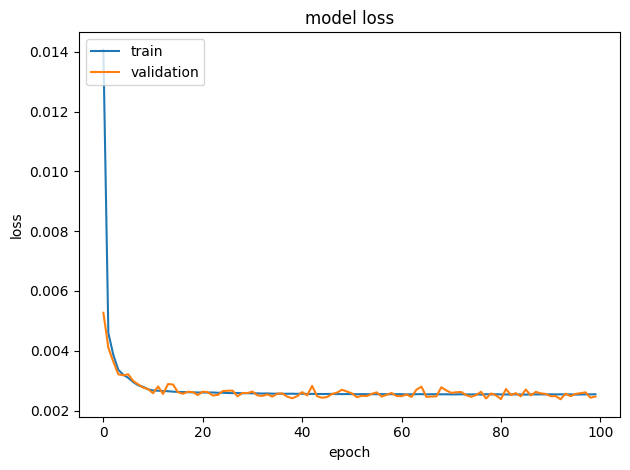

Evaluate on training data
  30/2500 [..............................] - ETA: 4s - loss: 0.0024  

2023-08-08 17:12:02.955358: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 23040000 exceeds 10% of free system memory.


2500/2500 [==============================] - 4s 1ms/step - loss: 0.0025
training loss: 0.0024633295834064484
Evaluate on test data
625/625 [==============================] - 1s 1ms/step - loss: 0.0025
test loss: 0.002465428551658988


In [12]:
# Loss
plt.plot(history_dif.history['loss'])
plt.plot(history_dif.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Evaluate the model on the test data using `evaluate`
print("Evaluate on training data")
results = model_dif.evaluate(train_dif_features, train_dif_labels, batch_size=128)
print("training loss:", results)
print("Evaluate on test data")
results = model_dif.evaluate(test_dif_features, test_dif_labels, batch_size=128)
print("test loss:", results)

1/1 [==============================] - 0s 16ms/step


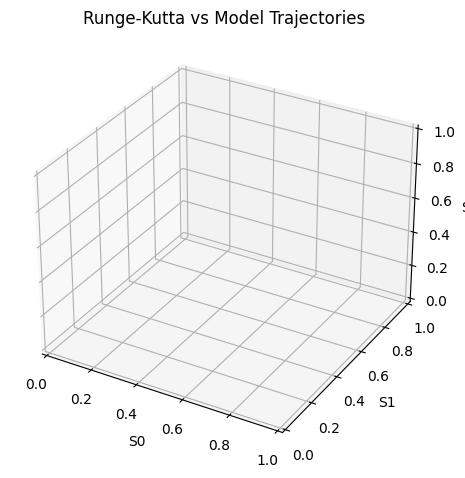

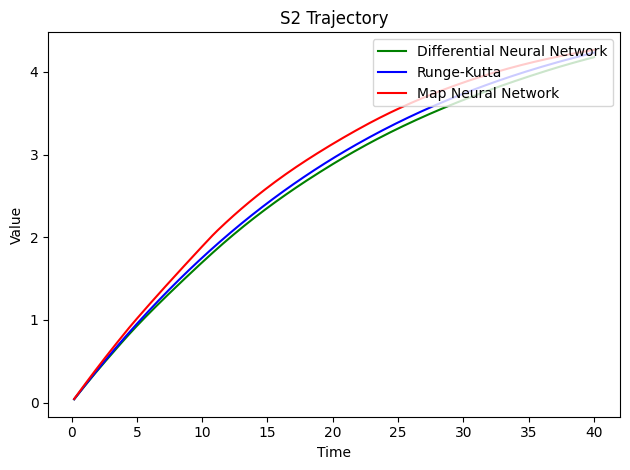

In [7]:
model_dif = keras.models.load_model("model_dif_params.tf")
model_map = keras.models.load_model("model_map_params.tf")
dt = 0.2
steps = 200

ax5 = plt.figure().add_subplot(projection='3d')
ax6 = plt.figure().add_subplot()

def f2(val, params):#based on the NN
    return model_dif.predict(np.concatenate((val, np.array(params).flatten())))[0]

def f_rk2(val, params, dt):
    k_1 = f2(val, params)*dt
    k_2 = f2(val + 0.5*k_1, params)*dt
    k_3 = f2(val + 0.5*k_2, params)*dt
    k_4 = f2(val + k_3, params)*dt
    nval = val + (1/6)*(k_1 + 2*k_2 + 2*k_3 + k_4)
    return nval
def integrate3(params):
    res_ar = []
    val_map = val_rk = val_dif = val_0
    time = 0.0
    for i in range(steps):
        val_rk = f_rk(val_rk, params, dt)
        val_map = model_map.predict(np.concatenate((val_map, np.array(params).flatten())))[0]
        val_dif = f_rk2(val_dif, params, dt)
        time += dt
        res_ar.append([time, val_map, val_rk, val_dif])
    res_ar = np.array(res_ar, dtype = object)
    return res_ar
def add_trajectory3(params):
    res_ar = integrate3(params)
    # ax5.plot([row[0] for row in res_ar[:,3]], [row[1] for row in res_ar[:,3]], [row[2] for row in res_ar[:,3]], color="green", label="Differential Neural Network")#Dif NN plot
    # ax5.plot([row[0] for row in res_ar[:,2]], [row[1] for row in res_ar[:,2]], [row[2] for row in res_ar[:,2]], color="blue", label="Runge Kutta")#Runge Kutta plot
    # ax5.plot([row[0] for row in res_ar[:,1]], [row[1] for row in res_ar[:,1]], [row[2] for row in res_ar[:,1]], color="red", label="Model Predicted")#Map NN plot
    ax6.plot(res_ar[:,0], [row[2] for row in res_ar[:,3]], color="green", label="Differential Neural Network")
    ax6.plot(res_ar[:,0], [row[2] for row in res_ar[:,2]], color="blue", label="Runge-Kutta")
    ax6.plot(res_ar[:,0], [row[2] for row in res_ar[:,1]], color="red", label="Map Neural Network")

add_trajectory3(np.array(params_0)*0.15)
# ran_sam = np.random.random_sample(size=(10, 3, 2))
# ran_sam = [(sam*0.25+np.array([[0.5,0.5],[0.5,0.5],[0.5,0.5]])*1.5) for sam in ran_sam]#random sample of deviation -75% -> -100%
# for s in ran_sam:
#     add_trajectory3(np.array(params_0)-np.multiply(params_0,s))

plt.rcParams["figure.autolayout"] = True
leg = plt.legend(loc='upper right')
# Set axes labels
ax5.set_xlabel("S0")
ax5.set_ylabel("S1")
ax5.set_zlabel("S2")
ax5.set_title("Runge-Kutta vs Model Trajectories")

ax6.set_xlabel("Time")
ax6.set_ylabel("Value")
ax6.set_title("S2 Trajectory")
plt.show()